In [51]:
using Plots
using Distributions
using LinearAlgebra
using Statistics

### Setup our ground truth and generate the data

In [52]:
# Ground truth; simply making it up
μ₁ = [-3,-7]
Σ₁ = [5 1.44; 1.44 5]

μ₂ = [5,2]
Σ₂ = [5 1; 1 5]

# println(isposdef(Σ₁))
# println(isposdef(Σ₂))

# Mixture of Gaussian
mixture = MixtureModel(MvNormal, [(μ₁, Σ₁), (μ₂, Σ₂)],[0.3, 0.7])

# Number of data points
N = 400

# Generate the data
data = rand(mixture,N);

### Plot the data we have generated

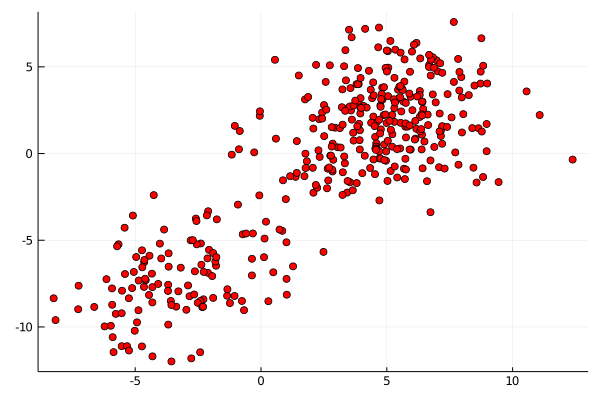

In [53]:
Plots.scatter(data[1,:], data[2,:], color="red", legend=false)

###  "Guess" a point to start from in the model's parameter space

In [54]:
#=
For EM, we always have to "guess" a point to start from in the model's parameter space
=#

# Randomly choose a mean for each Gaussian in the [-10,10]x[-10,10] box uniformly
random_mean = Product(Uniform.([-10 for i in 1:2], [10 for i in 1:2]))

# Choose points arbitrarily
est_λ₁ = 0.5;
est_λ₂ = 0.5;
est_μ₁ = rand(random_mean,1)[:,1]; # a guess
est_μ₂ = rand(random_mean,1)[:,1]; # another guess
est_Σ₁ = Matrix(1.0I,2,2);
est_Σ₂ = Matrix(1.0I,2,2);

# end of the "guess part"

### Define the subroutine that returns the log-likihood of the data

In [55]:
# given the model paramters, data, and the posterior of the hidden variable, return the incomplete log-likelihood
function log_likelihood(μ₁,μ₂,Σ₁,Σ₂,λ₁,λ₂,ws₁,ws₂,data)
    sum(ws₁ .* log.((pdf(MvNormal(μ₁, Σ₁), data) .* λ₁)./ ws₁))  + 
            sum(ws₂ .* log.((pdf(MvNormal(μ₂, Σ₂), data) .* λ₂)./ ws₂))
end

log_likelihood (generic function with 1 method)

### Define the EM optimization subroutine

In [56]:
tol = 1e-4; # "tolerence" for convergence criterion

# E step
function E_step(μ₁,μ₂,Σ₁,Σ₂,λ₁,λ₂,data)
    ws₁_xz = pdf(MvNormal(μ₁, Σ₁), data) .* λ₁;  # pdf function evaluates a batch of data points
    ws₂_xz = pdf(MvNormal(μ₂, Σ₂), data) .* λ₂;  
    ws₁ = ws₁_xz ./ (ws₁_xz + ws₂_xz);           # In Julia, a dot "." means the operation is applied elementwise 
    ws₂ = ws₂_xz ./ (ws₁_xz + ws₂_xz);
    return ws₁, ws₂
end

# M step
function M_step(μ₁,μ₂,Σ₁,Σ₂,λ₁,λ₂,ws₁,ws₂,data)
    
    vec1 = sqrt.(ws₁)' .* (data .- μ₁)
    vec2 = sqrt.(ws₂)' .* (data .- μ₂)
    
    Σ₁ = ( vec1 * vec1' ) ./ sum(ws₁)
    Σ₂ = ( vec2 * vec2' ) ./ sum(ws₂)
    
    μ₁ = (sum(ws₁' .* data, dims=2) / sum(ws₁))[:,1]
    μ₂ = (sum(ws₂' .* data, dims=2) / sum(ws₂))[:,1]
    
    λ₁ = sum(ws₁)/N
    λ₂ = sum(ws₂)/N
    
    return μ₁, μ₂, Σ₁, Σ₂, λ₁, λ₂
end

M_step (generic function with 1 method)

### Helper functions for visualization

In [57]:
# Here are simply helper functions that draws the Ellipse of Covariance Matrix
# Don't really need to dwell on this
# Details at https://cookierobotics.com/007/

tvec = range(0, 2π, length=100)

function parametric_fcn(Σ, μ)
    eigval = eigvals(Σ); eigvec = eigvecs(Σ);
    v1x = eigvec[1,1]; v2x = eigvec[1,2]; v1y = eigvec[2,1]; v2y = eigvec[2,2];
    α = sqrt(5.991) 
    X(t) = α * ( v1x * sqrt(eigval[1]) * cos.(t)  + v2x * sqrt(eigval[2]) * sin.(t) ) .+ μ[1]
    Y(t) = α * ( v1y * sqrt(eigval[1]) * cos.(t)  + v2y * sqrt(eigval[2]) * sin.(t) ) .+ μ[2]
    return X, Y
end

function plot_ellipse(Σ₁, μ₁, Σ₂, μ₂, color₁, color₂)
    X₁, Y₁ = parametric_fcn(Σ₁, μ₁)
    X₂, Y₂ = parametric_fcn(Σ₂, μ₂)
    Plots.scatter(data[1,:], data[2,:], color="red", legend=false)
    plot!(X₁(tvec), Y₁(tvec), color=color₁, xlims = (-15,15), ylims=(-15,15))
    plot!(X₂(tvec), Y₂(tvec), color=color₂, xlims = (-15,15), ylims=(-15,15))
    Plots.frame(anim)
end

plot_ellipse (generic function with 1 method)

### Optimize the log-likelihood

In [58]:
prev_ll = -Inf # previous log likelihood
ll = 0 # current log likelihood
iter = 1 # number of iterations

anim = Plots.Animation()
# while abs(prev_ll - ll) > tol

for i = 1:50
   
    # E step
    ws₁, ws₂ = E_step(est_μ₁,est_μ₂,est_Σ₁,est_Σ₂,est_λ₁,est_λ₂,data); 
            
    # calculate the log likelihood; print it out
    prev_ll = iter==1 ? prev_ll : ll;
    ll = log_likelihood(est_μ₁,est_μ₂,est_Σ₁,est_Σ₂,est_λ₁,est_λ₂,ws₁,ws₂,data);
    println("iteration: ", iter, ", log-likelihood: ", ll);
    iter += 1;
    
    # M step 
    est_μ₁, est_μ₂, est_Σ₁, est_Σ₂, est_λ₁, est_λ₂ = M_step(est_μ₁,est_μ₂,est_Σ₁,est_Σ₂,est_λ₁,est_λ₂,ws₁,ws₂,data);
    
    # Record whatthe covariance ellipse looks like
    plot_ellipse(est_Σ₁, est_μ₁, est_Σ₂, est_μ₂, "red", "blue");
    
    # convergence criterion
    if abs(prev_ll - ll) < tol
        break
    end
end

iteration: 1, log-likelihood: -10571.106040257873
iteration: 2, log-likelihood: -2186.8046496462302
iteration: 3, log-likelihood: -2051.079219323476
iteration: 4, log-likelihood: -2040.5584641026062
iteration: 5, log-likelihood: -2035.3633982299757
iteration: 6, log-likelihood: -2031.629963358398
iteration: 7, log-likelihood: -2028.6678908145227
iteration: 8, log-likelihood: -2026.0466255950046
iteration: 9, log-likelihood: -2023.343350507585
iteration: 10, log-likelihood: -2020.2410709792666
iteration: 11, log-likelihood: -2017.1274580665067
iteration: 12, log-likelihood: -2014.536048428479
iteration: 13, log-likelihood: -2012.2447934788006
iteration: 14, log-likelihood: -2009.9789109219876
iteration: 15, log-likelihood: -2007.6223982768634
iteration: 16, log-likelihood: -2005.1512899071467
iteration: 17, log-likelihood: -2002.6174050274492
iteration: 18, log-likelihood: -2000.1677681890449
iteration: 19, log-likelihood: -1998.0634477817039
iteration: 20, log-likelihood: -1996.5969455

┌ Info: Saved animation to 
│   fn = /home/shane/Desktop/code/EM toy examples/tmp.gif
└ @ Plots /home/shane/.julia/packages/Plots/E3MWZ/src/animation.jl:104


Plots.AnimatedGif("/home/shane/Desktop/code/EM toy examples/tmp.gif")
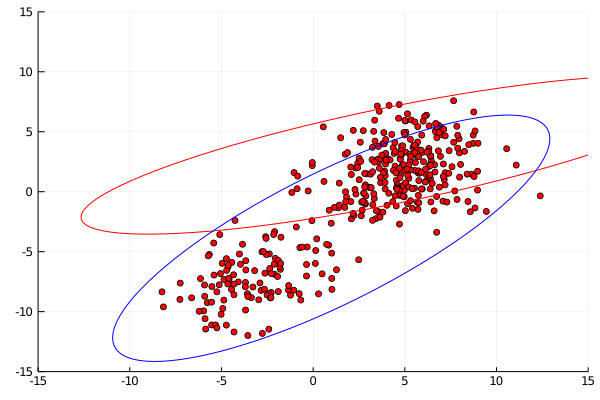

In [60]:
gif(anim, fps = 4)

In [44]:
# Mixture model like mixture of Gaussians are identifiable up to label switching
println("estimated mean: ", est_μ₁, " actual mean: ", μ₂) 

estimated mean: [4.94712, 1.94369] actual mean: [5, 2]


In [43]:
println("estimated mean: ", est_μ₂, " actual mean: ", μ₁) 

estimated mean: [-3.07512, -6.87155] actual mean: [-3, -7]


In [49]:
println("estimated covariance: ", est_Σ₁, " actual covariance: ", Σ₂) 

estimated covariance: [4.38461 0.970408; 0.970408 5.19032] actual covariance: [5 1; 1 5]


In [50]:
println("estimated covariance: ", est_Σ₂, " actual covariance: ", Σ₁) 

estimated covariance: [5.21136 1.6987; 1.6987 4.89615] actual covariance: [5.0 1.44; 1.44 5.0]


In [62]:
println("estimated weight ", est_λ₂, " actual weight: ", 0.3) 

estimated weight 0.2945028728772191 actual weight: 0.3


In [63]:
println("estimated weight ", est_λ₁, " actual weight: ", 0.7) 

estimated weight 0.7054971271227807 actual weight: 0.7
